# MS3D++ Tutorial

In this tutorial we show a simple demo of how MS3D++ can be used to generate labels for a folder of lidar point clouds.

For this demo, we use 2 pre-trained VoxelRCNNs (one trained on nuScenes, other trained on Lyft) to automatically label point clouds from a 128-beam Ouster OS1 lidar. In practice, we recommend using more than 2 detectors.

## Overview
MS3D++ can be broken down into 4 key steps as shown in the figure below. 

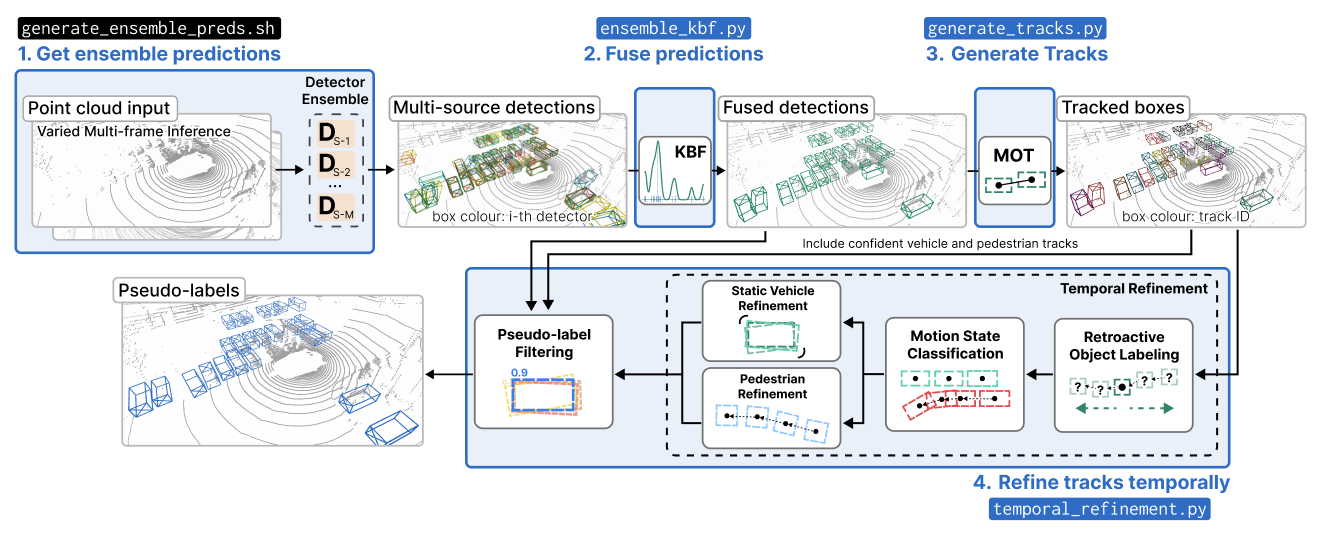

In [2]:
from IPython import display
display.Image("/MS3D/docs/media/ms3d++_tutorial.png")

The steps following the generation of detector predictions are contained in 3 python files (`ensemble_kbf.py`, `generate_tracks.py` and `temporal_refinement.py`) in the `/MS3D/tools` folder. However for this tutorial, we just import the key functions and walk through how it works.

## Setup

Please follow the installation instructions in `docs/INSTALL.md` before running this notebook.

In [1]:
# Basic setup
import sys
sys.path.append('/MS3D')
import numpy as np
import copy
import torch
import pickle
from demo_utils import visualize_bev
from demo_utils import load_dataset_and_model, load_yaml
from demo_utils import generate_predictions, format_ensemble_preds
from demo_dataset import DemoDataset
from pcdet.utils import box_fusion_utils, ms3d_utils, tracker_utils, common_utils
import pprint
pp = pprint.PrettyPrinter(depth=3, compact=True)
np.set_printoptions(suppress=True, precision=3)

sequence_name = 'sydney_ouster_sequence_60'
data_dir = f'/MS3D/tools/demo/{sequence_name}'
target_domain_cfg = load_yaml('/MS3D/tools/cfgs/dataset_configs/custom_dataset_da.yaml')

# Load in MS3D configs (only used in steps 2-4)
ms3d_configs = load_yaml('/MS3D/tools/demo/demo_ps_config.yaml')
!mkdir ps_labels

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. Get ensemble predictions
### Download pre-trained models and demo data

We first download 2 pre-trained models and their config files. **tdelta** refers to the maximum historical accumulation timeframe.
- VoxelRCNN (centerhead) trained on Lyft (3 sweeps; tdelta=0.4s)
- VoxelRCNN (centerhead) trained on nuScenes (10 sweeps; tdelta=0.45s)

We also download a folder of pointclouds (100 frames at 10Hz, ~180MB) that we collected in the University of Sydney campus using the 128-beam Ouster OS1 lidar.

In [ ]:
!pip install gdown
!mkdir pretrained

# Download model checkpoints
!cd pretrained && gdown https://drive.google.com/uc?id=1Bluez8vYBWC1Eo_9a9k1L1Oigquds843
!cd pretrained && gdown https://drive.google.com/uc?id=1J1Sjoyptir-yJQxYv0PsCr20xIDGA7Pf

# Download model config files
!cd pretrained && gdown https://drive.google.com/uc?id=1IV4-Nzc6M4EZ0WINMVi5bKGOxk7GScNr
!cd pretrained && gdown https://drive.google.com/uc?id=1UTwYKZ2jiVIomjKpNZJRS0YQNsgvaCYP
    
# Download our Sydney Ouster demo data 
!gdown https://drive.google.com/uc?id=1RFK3CGyWFMhXEOtFzGJbOD53DAhh77Bw -O sydney_ouster_sequence_60.tar.xz
!tar -xf sydney_ouster_sequence_60.tar.xz

### Generate lidar odometry

You can replace this odometry with your own method. MS3D++ just needs a list of 4x4 transform matrices that encodes the pose of the ego-vehicle for each point cloud with respect to a fixed frame (odom/global/map). 

We use the poses to concatenate historical frames with the current frame like how nuScenes does with their sweeps. You can see how we accumulate frames in `demo_dataset.get_sequence_data`

For our demo data, we use KISS-ICP to generate lidar odometry.

In [35]:
# Don't have to run this if you don't wish to, we already have lidar_odom.npy in the demo data folder
import glob

!pip install kiss-icp[all]
!kiss_icp_pipeline {sequence_name}/lidar
lidar_poses_path = glob.glob('results/*/*_poses.npy')[0]
!mv {lidar_poses_path} {sequence_name}/lidar_odom.npy
!rm -rf "results"


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Trying to guess how to read your data: `pip install "kiss-icp[all]"` is required
100%|████████████████████████████████████| 100/100 [00:16<00:00,  6.02 frames/s]
[WARNING] No GT poses available, skipping evaluation


We inspect this lidar odometry file below:

In [3]:
lidar_odom = np.load(f'{sequence_name}/lidar_odom.npy')
print(lidar_odom.shape) # we have 100 point clouds in our demo dataset, and a 4x4 tf matrix for each
pp.pprint(lidar_odom)

(100, 4, 4)
array([[[ 1.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  1.   ]],

       [[ 1.   ,  0.006,  0.006,  0.427],
        [-0.006,  1.   , -0.001, -0.005],
        [-0.006,  0.001,  1.   ,  0.03 ],
        [ 0.   ,  0.   ,  0.   ,  1.   ]],

       [[ 1.   ,  0.01 ,  0.011,  0.883],
        [-0.01 ,  1.   , -0.001, -0.019],
        [-0.011,  0.   ,  1.   ,  0.05 ],
        [ 0.   ,  0.   ,  0.   ,  1.   ]],

       ...,

       [[ 1.   , -0.025,  0.004, 55.661],
        [ 0.025,  1.   , -0.004, -0.328],
        [-0.004,  0.004,  1.   ,  1.343],
        [ 0.   ,  0.   ,  0.   ,  1.   ]],

       [[ 1.   , -0.025,  0.004, 56.338],
        [ 0.025,  1.   , -0.005, -0.318],
        [-0.004,  0.005,  1.   ,  1.359],
        [ 0.   ,  0.   ,  0.   ,  1.   ]],

       [[ 1.   , -0.025,  0.005, 57.001],
        [ 0.025,  1.   , -0.004, -0.31 ],
        [-0.005,  0.004,  1.   ,  1.38 ],

### Load models, data and generate predictions
In this section we build our ensemble using the two pre-trained models. For each model, we feed it with our demo data and generate a set of bounding boxes. We repeat this multiple times with different number of accumulated frames (i.e. varied multi-frame inference (VMFI)), and different test-time augmentation (tta) settings.

In this repository, we define 4 tta settings:

0. no tta
1. random world flip
2. random world rotation
3. random world flip + random world rotation

For our paper results, we use 8 pre-trained models on each target lidar dataset with a number of VMFI and TTA settings which can go up to a total of 64 detection sets. You can see how we generate prediction sets for the Waymo dataset [here](tools/cfgs/target_waymo/label_generation/round1/scripts/generate_ensemble_preds.sh) ## TODO: update this link

To keep things simple in this notebook, we generate 6 tta/sweep configs per detector, giving us 12 detection sets in total. The following section takes a few minutes to generate multiple prediction sets.

**Note:** If you wish to quickly move on in this tutorial, we provide a download link to a pre-generated `detection_sets` dict in the next cell.

In [7]:
# Model ckpt, configs and dataset directory
vx_c_lyft_pth = 'pretrained/lyft_uda_voxel_rcnn_centerhead_3xyzt_allcls.pth'
vx_c_lyft_yaml = 'pretrained/lyft_uda_voxel_rcnn_centerhead_3xyzt_allcls.yaml'
vx_c_nusc_pth = 'pretrained/nuscenes_uda_voxel_rcnn_centerhead_10xyzt_allcls.pth'
vx_c_nusc_yaml = 'pretrained/nuscenes_uda_voxel_rcnn_centerhead_10xyzt_allcls.yaml'

# Generate predictions.
# You need around 12GB GPU memory and 10 mins to run this on a 2080TI with batch_size=4. Lower batch_size as needed.
batch_size = 2
ensemble_preds = {}
dataset, model = load_dataset_and_model(data_dir=data_dir,
                                        ckpt_path=vx_c_lyft_pth,
                                        model_yaml=vx_c_lyft_yaml,
                                        ext='.pcd')    
ensemble_preds['vx_c_lyft_tta0_sweeps1'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=1, tta_setting=0)
ensemble_preds['vx_c_lyft_tta3_sweeps1'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=1, tta_setting=3)
ensemble_preds['vx_c_lyft_tta0_sweeps3'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=3, tta_setting=0)
ensemble_preds['vx_c_lyft_tta3_sweeps3'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=3, tta_setting=3)
ensemble_preds['vx_c_lyft_tta0_sweeps5'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=5, tta_setting=0)
ensemble_preds['vx_c_lyft_tta3_sweeps5'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=5, tta_setting=3)

dataset, model = load_dataset_and_model(data_dir=data_dir,
                                        ckpt_path=vx_c_nusc_pth,
                                        model_yaml=vx_c_nusc_yaml,
                                        ext='.pcd')    
ensemble_preds['vx_c_nusc_tta0_sweeps1'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=1, tta_setting=0)
ensemble_preds['vx_c_nusc_tta3_sweeps1'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=1, tta_setting=3)
ensemble_preds['vx_c_nusc_tta0_sweeps3'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=3, tta_setting=0)
ensemble_preds['vx_c_nusc_tta3_sweeps3'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=3, tta_setting=3)
ensemble_preds['vx_c_nusc_tta0_sweeps5'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=5, tta_setting=0)
ensemble_preds['vx_c_nusc_tta3_sweeps5'] = generate_predictions(model, dataset, 
                                                                batch_size=batch_size, sweeps=5, tta_setting=3)

# Format the dict for MS3D compatibility
ensemble_preds = format_ensemble_preds(ensemble_preds)
detection_sets = box_fusion_utils.get_detection_sets(ensemble_preds, score_th=0.1)

with open('ps_labels/detection_sets.pkl','wb') as f:
    pickle.dump(detection_sets, f)

# clear gpu memory
del model
torch.cuda.empty_cache()

2023-09-14 07:37:19,905   INFO  ==> Loading parameters from checkpoint pretrained/lyft_uda_voxel_rcnn_centerhead_3xyzt_allcls.pth to CPU
2023-09-14 07:37:19,905   INFO  ==> Loading parameters from checkpoint pretrained/lyft_uda_voxel_rcnn_centerhead_3xyzt_allcls.pth to CPU
2023-09-14 07:37:19,905   INFO  ==> Loading parameters from checkpoint pretrained/lyft_uda_voxel_rcnn_centerhead_3xyzt_allcls.pth to CPU
2023-09-14 07:37:19,991   INFO  ==> Checkpoint trained from version: pcdet+0.6.0+
2023-09-14 07:37:19,991   INFO  ==> Checkpoint trained from version: pcdet+0.6.0+
2023-09-14 07:37:19,991   INFO  ==> Checkpoint trained from version: pcdet+0.6.0+
2023-09-14 07:37:20,013   INFO  ==> Done (loaded 303/303)
2023-09-14 07:37:20,013   INFO  ==> Done (loaded 303/303)
2023-09-14 07:37:20,013   INFO  ==> Done (loaded 303/303)
100%|███████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]
2023-09-14 07:45:43,977   INFO  ==> Loading parameters from checkpoint pretrained/nuscen

The cell below downloads the `detection_sets` list if you do not wish to run the above cell.

In [2]:
!gdown https://drive.google.com/uc?id=19hScVTh_YVqJj3Xl0XiXbhp0nZuolAt3 -O ps_labels/detection_sets.pkl
with open('ps_labels/detection_sets.pkl','rb') as f:
    detection_sets = pickle.load(f)

`detection_sets` contains the predictions of each pre-trained model with specific tta/sweep settings on the target domain. 

Each frame's prediction contains `boxes_lidar` which is a (N,7) array that specifies a 3D bounding box as `centre_x,centre_y,centre_z,dim_x,dim_y_dim_z,heading`.

In [3]:
print(f'Num frames: {len(detection_sets)}')
print(f'Num detection sets: {len(np.unique(detection_sets[0]["source_id"]))}')
print(f'Keys: {list(detection_sets[0].keys())}')
print(f'boxes_lidar: {detection_sets[0]["boxes_lidar"].shape}')

Num frames: 100
Num detection sets: 12
Keys: ['boxes_lidar', 'score', 'source', 'source_id', 'frame_id', 'class_ids', 'names', 'box_weights']
boxes_lidar: (1272, 7)


### Visualize detection sets

Now let's visualize all the 12 detection sets! Each color is a different detection set.

<IPython.core.display.Javascript object>


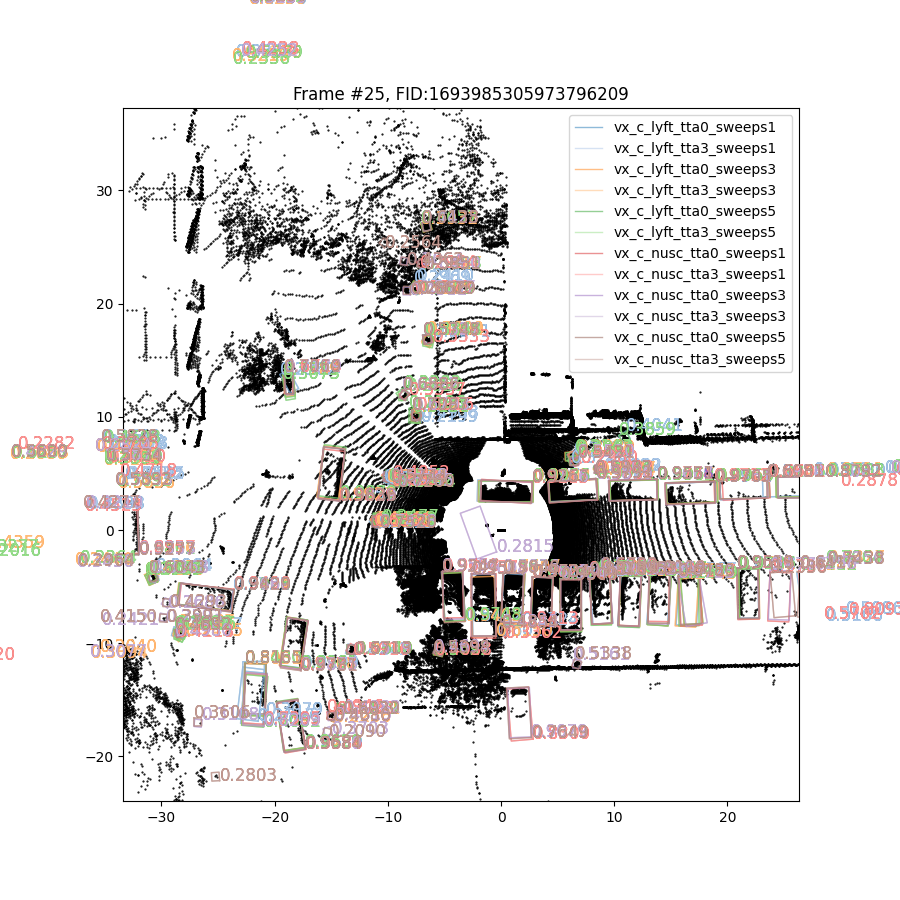

In [24]:
%matplotlib notebook

dataset = DemoDataset(
        dataset_cfg=target_domain_cfg, class_names=target_domain_cfg.CLASS_NAMES, training=False,
        root_path=data_dir, ext='.pcd', logger=common_utils.create_logger(), sweeps=1
    )

# This is interactive. Use the buttons below to zoom in/zoom out/move around.
fig, ax = visualize_bev(dataset, idx=25, detection_sets=detection_sets, show_legend=True)

## 2. Fuse all detection sets with KBF

In this step, we simply fuse all the different prediction sets above into a single detection set. The code for this step is contained within `tools/ensemble_kbf.py`

In [7]:
# Get class specific pseudo-labeling config
cls_kbf_config = {}
for enum, cls in enumerate(box_fusion_utils.SUPERCATEGORIES): 
    if cls in cls_kbf_config.keys():
        continue
    cls_kbf_config[cls] = {}
    cls_kbf_config[cls]['cls_id'] = enum+1 # in OpenPCDet, cls_ids enumerate from 1
    cls_kbf_config[cls]['discard'] = ms3d_configs['ENSEMBLE_KBF']['DISCARD'][enum]
    cls_kbf_config[cls]['radius'] = ms3d_configs['ENSEMBLE_KBF']['RADIUS'][enum]
    cls_kbf_config[cls]['nms'] = ms3d_configs['ENSEMBLE_KBF']['NMS'][enum]
    cls_kbf_config[cls]['neg_th'] = ms3d_configs['PS_SCORE_TH']['NEG_TH'][enum]

# Fuse boxes
ps_dict = box_fusion_utils.get_initial_pseudo_labels(detection_sets, cls_kbf_config)

with open('ps_labels/initial_ps_labels.pkl', 'wb') as f:
    pickle.dump(ps_dict, f)

get initial ps labels: 100%|██████████████████| 100/100 [00:17<00:00,  5.56it/s]


The keys of `ps_dict` are the frame_ids, and the values contain a dict that includes our initial pseudo-labels (`gt_boxes`) as well as any other metadata (we don't have any other for now). 

`gt_boxes` is a (N,9) array where each box is now `centre_x,centre_y,centre_z,dim_x,dim_y_dim_z,heading,class_id,score`

### Visualize initial pseudo-labels

Now let's visualize the fused pseudo-label set! We overlay them over the 12 detection sets so you can get an idea of the before/after fusion.

**Tip**: it helps to pause here and properly set the following configs because the confidence scores of each pre-trained detector may vary depending on the lidar that you are testing them on.
- `ms3d_configs.PS_SCORE_TH.POS_TH`
- `ms3d_configs.TRACKING`

<IPython.core.display.Javascript object>


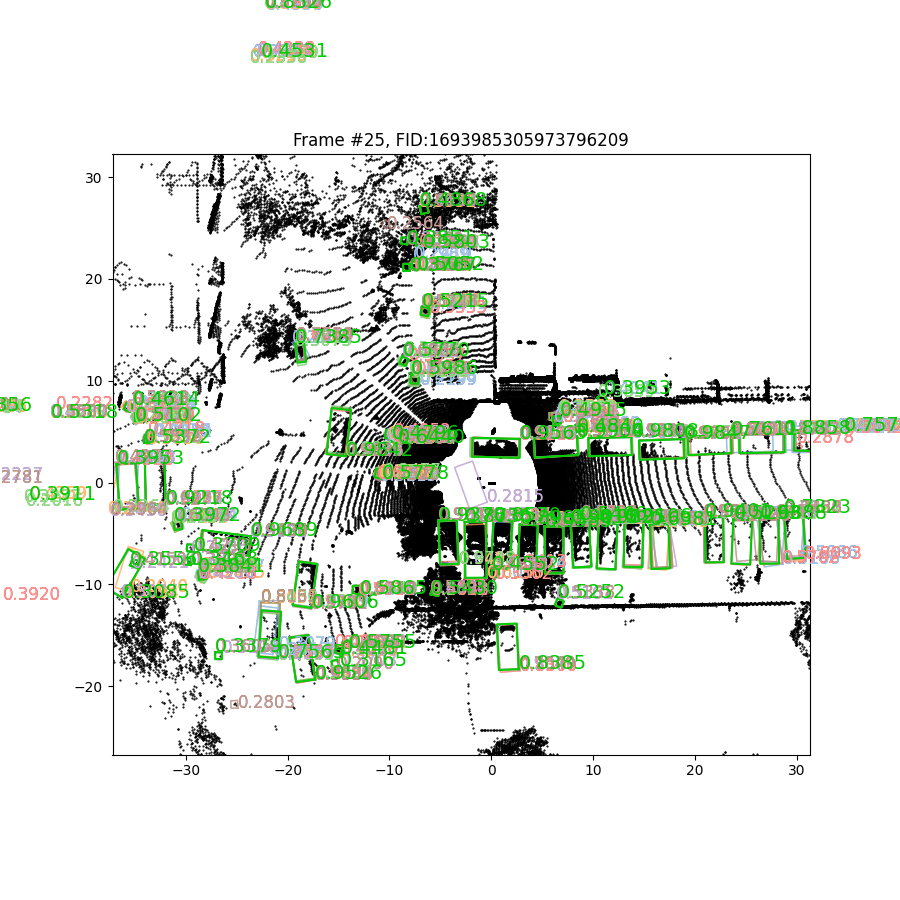

In [22]:
%matplotlib notebook

dataset = DemoDataset(
        dataset_cfg=target_domain_cfg, class_names=target_domain_cfg.CLASS_NAMES, training=False,
        root_path=data_dir, ext='.pcd', logger=common_utils.create_logger(), sweeps=1
    )

# This is interactive. Use the buttons below to zoom in/zoom out/move around.
fig, ax = visualize_bev(dataset, idx=25, ps_dict=ps_dict, detection_sets=detection_sets, show_legend=False)

## 3. Generate tracks

In this section, we generate tracks for the single set of detection boxes for our lidar data. We generate 3 sets of tracks:
- Vehicle (all)
- Vehicle (static)
- Pedestrian

The Vehicle (all) and Pedestrian tracks are just generic tracking configs using generalized IOU (introduced in SimpleTrack) that are tweaked to work best for both dynamic and static objects. 

For Vehicle (static), we use a strict iou matching criterion using 2D IOU with `IOU > 0.5`. This is because if we loosely match a parked car with poorly localized boxes that are more than 1m away, the track may now appear to be moving. Later on, we project both the refined parked cars and Vehicle (all) tracks and filter with NMS (we set a high confidence score for parked cars that have been refined).

The code for this step is contained within `tools/generate_tracks.py`

In [6]:
target_domain_cfg = load_yaml('/MS3D/tools/cfgs/dataset_configs/custom_dataset_da.yaml')
dataset = DemoDataset(
        dataset_cfg=target_domain_cfg, class_names=target_domain_cfg.CLASS_NAMES, training=False,
        root_path=data_dir, ext='.pcd', logger=common_utils.create_logger(), sweeps=1
    )

trk_cfg = tracker_utils.prepare_track_cfg(ms3d_configs['TRACKING']['VEH_ALL'])
tracks_veh_all = tracker_utils.get_tracklets(dataset, ps_dict, trk_cfg, cls_id=1)

trk_cfg = tracker_utils.prepare_track_cfg(ms3d_configs['TRACKING']['VEH_STATIC'])
tracks_veh_static = tracker_utils.get_tracklets(dataset, ps_dict, trk_cfg, cls_id=1)

trk_cfg = tracker_utils.prepare_track_cfg(ms3d_configs['TRACKING']['PEDESTRIAN'])
tracks_ped = tracker_utils.get_tracklets(dataset, ps_dict, trk_cfg, cls_id=2)

with open('ps_labels/tracks_veh_all.pkl', 'wb') as f:
    pickle.dump(tracks_veh_all, f)
with open('ps_labels/tracks_veh_static.pkl', 'wb') as f:
    pickle.dump(tracks_veh_static, f)
with open('ps_labels/tracks_ped.pkl', 'wb') as f:
    pickle.dump(tracks_ped, f)    

generate_trks:   1%|▎                           | 1/100 [00:00<00:11,  8.59it/s]

Initialising tracker for sequence: demo_sequence, track_id: 0


generate_trks:   1%|▎                           | 1/100 [00:00<00:14,  7.06it/s]

Initialising tracker for sequence: demo_sequence, track_id: 0


generate_trks:   1%|▎                           | 1/100 [00:00<00:12,  8.07it/s]

Initialising tracker for sequence: demo_sequence, track_id: 0


generate_trks: 100%|██████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


Each track is a dictionary with the key representing the track_id for each object in the sequence.

### Visualize tracks

Here we visualize the pedestrian tracks. The numbers are the object track_ids.

**Tip**: It helps to pause here to properly set the `ms3d_configs.TEMPORAL_REFINEMENT.TRACK_FILTERING`. Or come back to this step later on after generating the final pseudo-label set.

In [11]:
with open('ps_labels/tracks_veh_all.pkl', 'rb') as f:
    tracks_veh_all = pickle.load(f)
with open('ps_labels/tracks_veh_static.pkl', 'rb') as f:
    tracks_veh_static = pickle.load(f)
with open('ps_labels/tracks_ped.pkl', 'rb') as f:
    tracks_ped = pickle.load(f)

<IPython.core.display.Javascript object>


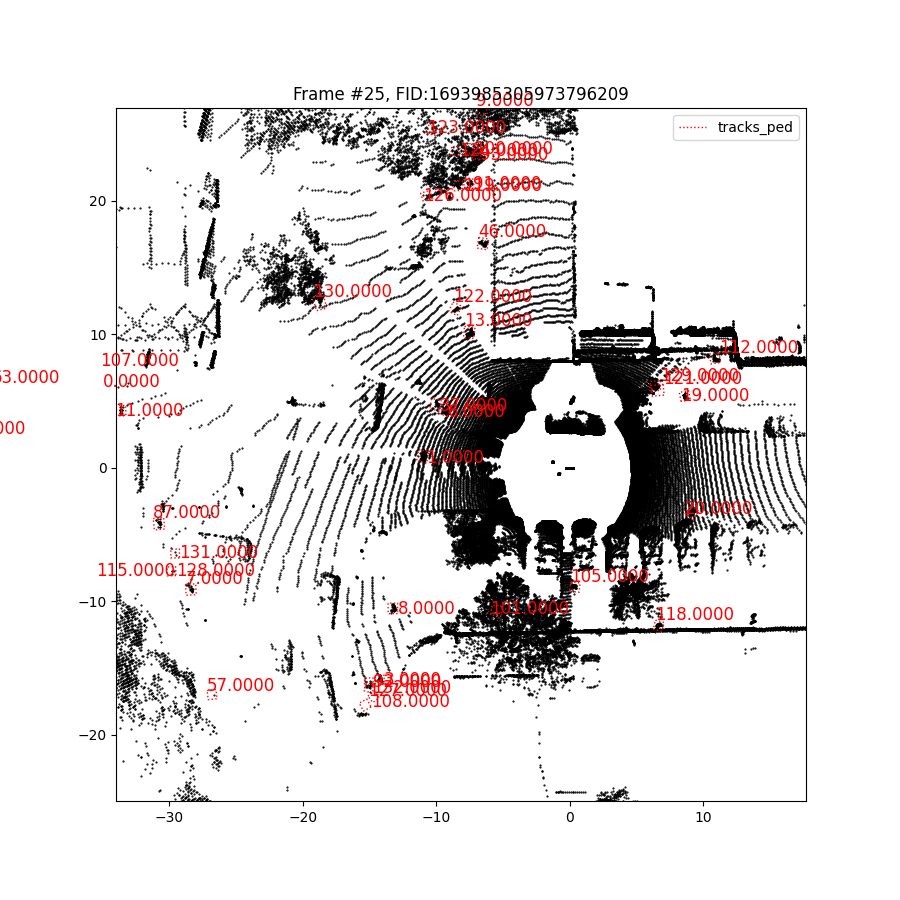

In [19]:
%matplotlib notebook

dataset = DemoDataset(
        dataset_cfg=target_domain_cfg, class_names=target_domain_cfg.CLASS_NAMES, training=False,
        root_path=data_dir, ext='.pcd', logger=common_utils.create_logger(), sweeps=1
    )

# This is interactive. Use the buttons below to zoom in/zoom out/move around.
# if show_trk_score=False, number=track_id, else number=conf_score. show_score=False just hides the number
fig, ax = visualize_bev(dataset, idx=25, tracks=tracks_ped, tracks_legend='tracks_ped',
              show_trk_score=False, show_score=True) 

# 4. Refine tracks temporally
In this step, we use temporal information to refine our pseudo-labels. We first classify each object as static or dynamic, then refine them accordingly.

For both vehicle and pedestrian refinement (in refine_veh_labels and refine_ped_labels), we first filter the object tracks specifying a minimum number of tracks, as well as the minimum number of tracks that have to be above the a confidence score threshold `PS_SCORE_TH.POS_TH`. Following that, we further elaborate below.

**Vehicle Refinement (refine_veh_labels)**: We use KBF to fuse multiple detection boxes of a single static vehicle. We don't use all the detection boxes but rather a sliding window where the window size (i.e. num. frames) is determined by `ROLLING_KDE_WINDOW` in the config file `demo_ps_config.yaml`. The confidence score of refined boxes are re-adjusted to `max(MIN_STATIC_SCORE, pred_score)` so it doesn't get filtered out by NMS later on.

**Pedestrian Refinement (refine_ped_labels)**: We separate pole-like false positives from true pedestrians by only keeping tracks that are dynamic. Likewise, we also re-adjust the confidence score to `max(PS_SCORE_TH.POS_TH, pred_score)`.

**Final refinement (update_ps)**: Project initial pseudo-labels and refined tracks (including Vehicle (all)) into the frame then filter with NMS. We also remove any bounding box that has no points inside.

**Select pseudo-label (select_ps_by_th)**: Use detection boxes if their confidence score is above `PS_SCORE_TH.POS_TH`, specified in `demo_ps_config.yaml`. 

The code for this step is contained within `tools/temporal_refinement.py`

In [9]:
tracks_veh_all_refined, tracks_veh_static_refined = ms3d_utils.refine_veh_labels(
                                dataset,list(ps_dict.keys()),
                                copy.deepcopy(tracks_veh_all), 
                                copy.deepcopy(tracks_veh_static), 
                                static_trk_score_th=ms3d_configs['TRACKING']['VEH_STATIC']['RUNNING']['SCORE_TH'],
                                veh_pos_th=ms3d_configs['PS_SCORE_TH']['POS_TH'][0],
                                refine_cfg=ms3d_configs['TEMPORAL_REFINEMENT'],
                                save_dir=None
                                )

tracks_ped_refined = ms3d_utils.refine_ped_labels(copy.deepcopy(tracks_ped), 
                                ped_pos_th=ms3d_configs['PS_SCORE_TH']['POS_TH'][1],
                                track_filtering_cfg=ms3d_configs['TEMPORAL_REFINEMENT']['TRACK_FILTERING']
                                )

final_ps_labels = ms3d_utils.update_ps(dataset, ps_dict, 
                                       tracks_veh_all_refined, tracks_veh_static_refined, tracks_ped_refined, 
                                       veh_pos_th=ms3d_configs['PS_SCORE_TH']['POS_TH'][0], 
                                       veh_nms_th=0.05, ped_nms_th=0.5, 
                                       frame2box_key_static='frameid_to_propboxes', 
                                       frame2box_key='frameid_to_box', frame_ids=list(ps_dict.keys())
                                       )

final_ps_labels = ms3d_utils.select_ps_by_th(final_ps_labels, ms3d_configs['PS_SCORE_TH']['POS_TH'])

with open('ps_labels/final_ps_labels.pkl', 'wb') as f:
    pickle.dump(final_ps_labels, f)

update_ps: 100%|██████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


That's it! You've just generated labels `final_ps_labels` for the folder of point clouds. Refer to `GETTING_STARTED.md` for general usage instructions for MS3D.

To process multiple sequences of your own dataset, please refer to `CUSTOM_DATASET_TUTORIAL.md`. If there are any questions or issues, feel free to open an issue or email me at darrenjktsai@gmail.com!

### Visualize final pseudo-labels

We can visualize the labels to check their quality before training. It helps to cross-check with camera images to see if the labels are correct. Projecting the 3D labels into each camera image for visual assessment would be ideal if you have a time-synced and well-calibrated setup.

<IPython.core.display.Javascript object>


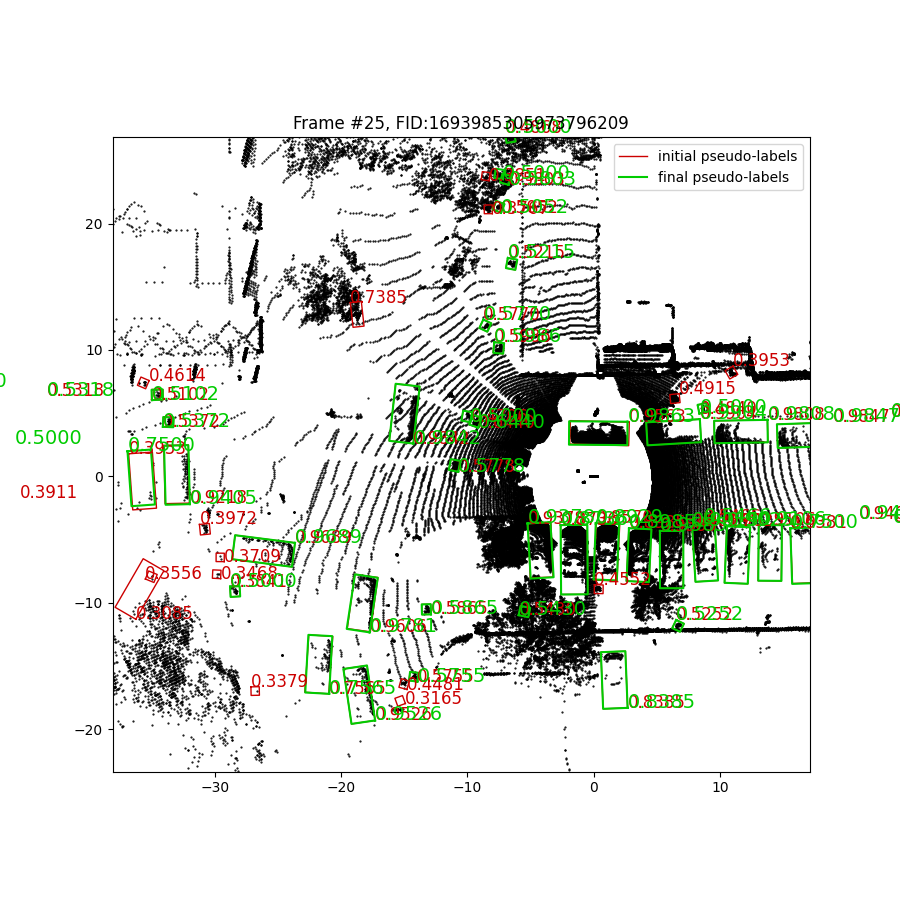

In [21]:
%matplotlib notebook

dataset = DemoDataset(
        dataset_cfg=target_domain_cfg, class_names=target_domain_cfg.CLASS_NAMES, training=False,
        root_path=data_dir, ext='.pcd', logger=common_utils.create_logger(), sweeps=1
    )

# This is interactive. Use the buttons below to zoom in/zoom out/move around.
fig, ax = visualize_bev(dataset, idx=25, ps_dict=final_ps_labels, ps_dict2=ps_dict, 
              ps_dict_legend='final pseudo-labels', ps_dict2_legend='initial pseudo-labels',
              show_score=True,
              above_pos_th=True)

# Final comments and tips

Overall, the idea is not to get a perfect label set in the 1st round of training, but rather to make it quite strict (e.g. with higher thresholds like `POS_TH: [0.8,0.6,0.5]` and `TRACK_FILTERING`) so that we minimise the number of false positive labels. It is very hard to get rid of false positives in later rounds of self-training. 

After a few rounds of self-training and re-labeling of the same training dataset, we should get more confident labels for objects that we couldn't even detect in earlier rounds. 

**Tip 1:** For better quality labels, we recommend using more pre-trained detectors in the ensemble than just 2. In our paper we used 8 pre-trained detectors. You can play around with which detectors and what weights to use for each detector in the ensemble. 

**Tip 2:** If you wonder why some objects are not labelled for final_ps_dict, it helps to inspect the tracks in step 3 to check if they were filtered out in step 4 by any of the following configs in `demo_ps_config.yaml`:
```
PS_SCORE_TH: # veh,ped,cyc; cyclist not supported at the moment
  POS_TH: [0.7,0.5,0.5]
  NEG_TH: [0.3,0.2,0.2]

TEMPORAL_REFINEMENT:
  TRACK_FILTERING:
    MIN_NUM_STATIC_VEH_TRACKS: 10
    MIN_NUM_PED_TRACKS: 10
    MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_VEH_ALL: 12
    MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_VEH_STATIC: 2
    MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_PED: 2
    USE_STATIC_PED_TRACKS: false    
```

### Simple example of how to understand and tune the configs
In the image and BEV plot below, objects with track_ids 129, 121 and 19 are pedestrians but 112 is not. In our final pseudo-label set, only 19 was labeled as a pedestrian while 129 and 121 were not. 

<IPython.core.display.Javascript object>


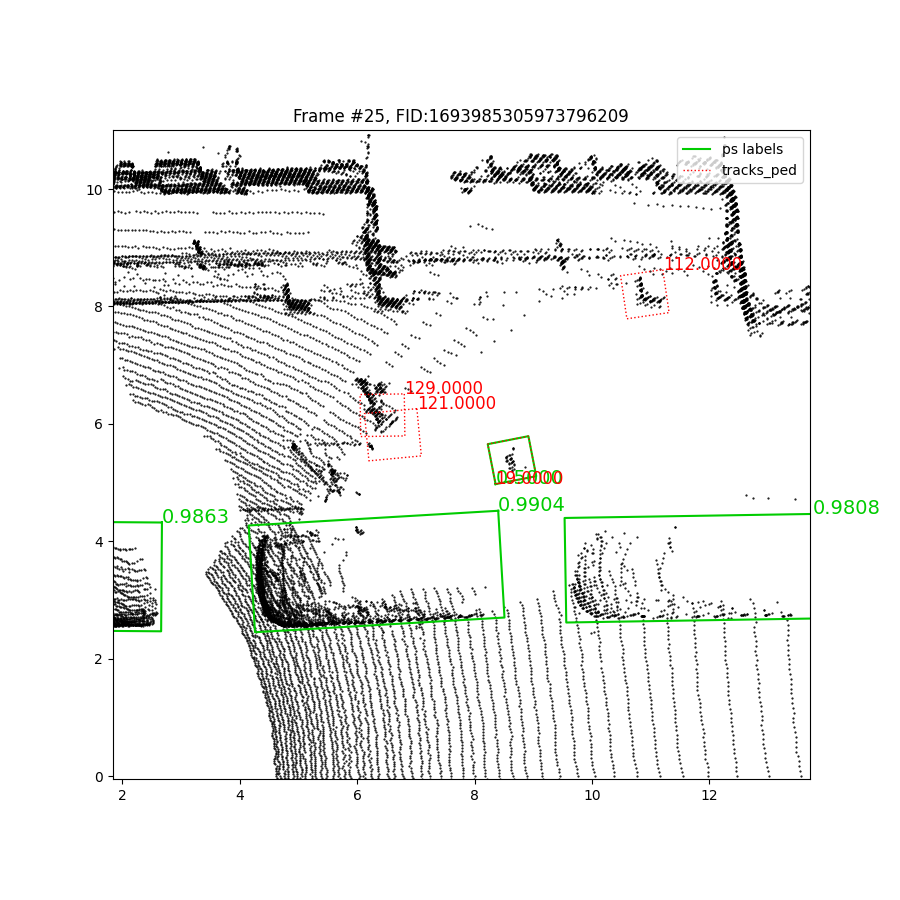

In [23]:
%matplotlib notebook

dataset = DemoDataset(
        dataset_cfg=target_domain_cfg, class_names=target_domain_cfg.CLASS_NAMES, training=False,
        root_path=data_dir, ext='.pcd', logger=common_utils.create_logger(), sweeps=1
    )

# This is interactive. Use the buttons below to zoom in/zoom out/move around.
# if show_trk_score=False, number=track_id, else number=conf_score. show_score=False just hides the number
visualize_bev(dataset, idx=25, tracks=tracks_ped, tracks_legend='tracks_ped', ps_dict=final_ps_labels,
              show_trk_score=False, show_score=True, above_pos_th=True) 

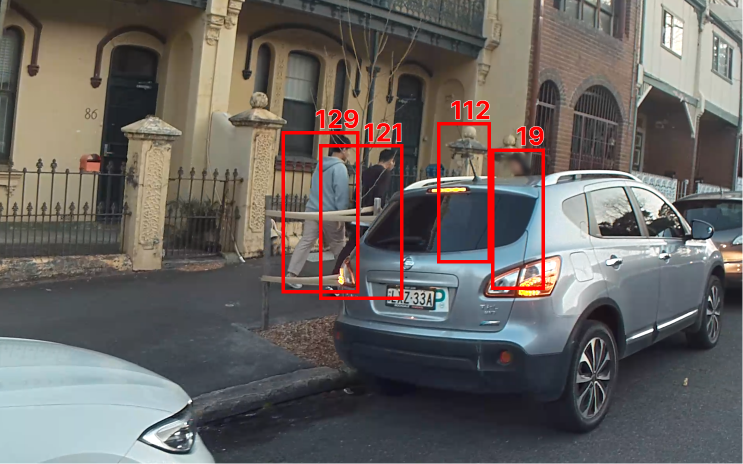

In [41]:
from IPython import display
display.Image("/MS3D/tools/demo/sydney_ouster_sequence_60/tutorial_tuning_tips.png")

You can inspect the track ids and find out if they are filtered out according to the configuration specified above. 

Looking at track id 129, we can see below that it ticked all the boxes except that the pedestrian track was considered as a static track because the guy didn't walk very far during the short tracking sequence. Since we don't use static pedestrian tracks for the 1st round, we therefore filtered this track out. 

If you set the start to end distance threshold `s2e_th=1`, track 129 would be considered dynamic, and this may work for your dataset but note that you may also include more false positive pedestrian tracks due to poor track extrapolation in other cases.

In [17]:
trk_filt_cfg = ms3d_configs.TEMPORAL_REFINEMENT.TRACK_FILTERING
print(f'-------------------CONFIG----------------------')
print(f'MIN_NUM_PED_TRACKS: {trk_filt_cfg.MIN_NUM_PED_TRACKS}')
print(f'MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_PED: {trk_filt_cfg.MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_PED}')
print(f'USE_STATIC_PED_TRACKS: {trk_filt_cfg.USE_STATIC_PED_TRACKS}')

print(f'\n-------------------TRACK----------------------')
trk_boxes = np.array(tracks_ped[129]["boxes"])
min_ped_tracks = len(trk_boxes)
min_dets_above_pos_th = len(trk_boxes[:,7] >= ms3d_configs.PS_SCORE_TH.POS_TH[1])
motion_state = tracker_utils.get_motion_state(trk_boxes,s2e_th=2) # for ped, default is s2e_th=2
if (not trk_filt_cfg.USE_STATIC_PED_TRACKS) and (motion_state == 0):
    motion_passes_filtering = False
else:
    motion_passes_filtering = True

print(f'NUM PED TRACKS: {min_ped_tracks} [{min_ped_tracks >= trk_filt_cfg.MIN_NUM_PED_TRACKS}]')
print(f'NUM DETS ABOVE POS TH: {min_dets_above_pos_th} \
        [{min_dets_above_pos_th >= trk_filt_cfg.MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_PED}]')
print(f'MOTION STATE (dynamic=1,static=0): {motion_state} [{motion_passes_filtering}]')
print('\nSince pedestrian track is classified as static, we do not use it')

-------------------CONFIG----------------------
MIN_NUM_PED_TRACKS: 10
MIN_DETS_ABOVE_POS_TH_FOR_TRACKS_PED: 2
USE_STATIC_PED_TRACKS: False

-------------------TRACK----------------------
NUM PED TRACKS: 10 [True]
NUM DETS ABOVE POS TH: 10         [True]
MOTION STATE (dynamic=1,static=0): 0 [False]

Since pedestrian track is classified as static, we do not use it
